## Installing and Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline

#### Max Display Disable

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Importing Dataset of the tracks 

In [5]:
df = pd.read_csv('/content/drive/MyDrive/tracks.csv')
df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a artist.csv file that should have some useful information


## Importing Dataset of the artist and genres

In [6]:
df_genres = pd.read_csv('/content/drive/MyDrive/data_by_artist_o.csv')
df_genres.tail()

genres artists  \
28675                                                 []     麥志誠   
28676  ['c-pop', 'classic cantopop', 'classic mandopo...     黃品源   
28677                                                 []     黃國隆   
28678            ['chinese indie', 'chinese indie rock']      黑豹   
28679                             ['classic korean pop']     조정현   

       acousticness  danceability    duration_ms  energy  instrumentalness  \
28675      0.512000      0.356000  198773.000000  0.3060          0.008970   
28676      0.541000      0.578000  293840.000000  0.3340          0.000006   
28677      0.785455      0.570818  174582.727273  0.1484          0.000083   
28678      0.381000      0.353000  316160.000000  0.6860          0.000000   
28679      0.568000      0.447000  237688.000000  0.2150          0.000001   

       liveness   loudness  speechiness       tempo   valence  popularity  \
28675  0.108000 -10.119000     0.027700  150.049000  0.328000        35.0   
28676  0.067500 -11.974000     0.026700  135.934000  0.243000        48.0   
28677  0.142191 -21.610091     0.054355  119.586273  0.741273        23.0   
28678  0.056800  -9.103000     0.039500  200.341000  0.352000        35.0   
28679  0.064900 -16.478000     0.027200   71.979000  0.177000        31.0   

       key  mode  count  
28675   10     1      2  
28676    9     0      2  
28677    5     1     11  
28678   11     1      2  
28679   10     1      2

The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [7]:
df_genres.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [8]:
df_genres.shape

(28680, 16)

In [9]:
df.shape

(586672, 20)

In [10]:
df_genres['genres'].tail()

28675                                                   []
28676    ['c-pop', 'classic cantopop', 'classic mandopo...
28677                                                   []
28678              ['chinese indie', 'chinese indie rock']
28679                               ['classic korean pop']
Name: genres, dtype: object

In [11]:
df_genres['genres_upd'] = df_genres['genres'].apply(lambda x:[re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])

In [12]:
df_genres['genres_upd'].tail().values[1][0]

'c-pop'

In [13]:
# Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:

# Explode artists column in the previous so each artist within a song will have their own row
# Merge data_w_genre to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

In [14]:
df['artists_upd_v1'] = df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [15]:
df['artists_upd_v1'].values[0]


['Uli']

In [16]:
df[df['artists_upd_v1'].apply(lambda x: not x)].head(5)

id                     name  popularity  duration_ms  \
164  1xEEYhWxT4WhDQdxfPCT8D                Snake Rag          20       194533   
170  3rauXVLOOM5BlxWqUcDpkg             Chimes Blues          14       170827   
172  1UdqHVRFYMZKU2Q7xkLtYc     Pickin' On Your Baby          11       197493   
174  0Vl2DO5U6FjgBpzCtBN3OA  Everybody Loves My Baby          10       152507   
180  5SvyP1ZeJX1jA7AOZD08NA                    Tears          10       187227   

     explicit                             artists                  id_artists  \
164         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
170         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
172         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
174         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
180         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   

    release_date  danceability  energy  key  loudness  mode  speechiness  \
164         1923         0.708   0.361    0   -11.764     0       0.0441   
170         1923         0.546   0.189    0   -15.984     1       0.0581   
172         1923         0.520   0.153    0   -14.042     1       0.0440   
174         1923         0.514   0.193    2   -13.920     0       0.2380   
180         1923         0.359   0.357    3   -11.810     1       0.0511   

     acousticness  instrumentalness  liveness  valence    tempo  \
164         0.994             0.883     0.103    0.902  105.695   
170         0.996             0.908     0.339    0.554   80.318   
172         0.995             0.131     0.353    0.319  102.937   
174         0.996             0.199     0.248    0.665  180.674   
180         0.994             0.819     0.290    0.753  205.053   

     time_signature artists_upd_v1  
164               4             []  
170               4             []  
172               4             []  
174               4             []  
180               4             []

In [17]:
df['artists_upd_v2'] = df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
df['artists_upd'] = np.where(df['artists_upd_v1'].apply(lambda x: not x), df['artists_upd_v2'], df['artists_upd_v1'] )

In [18]:
for i in range(0, len(df['name'])):
    if type(df['name'][i]) == float:
        df['name'][i]= str(df['name'][i])

In [19]:
df['artists_song'] = df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [20]:
df[df['name']=='Adore You']

id       name  popularity  duration_ms  explicit  \
86217  5AnCLGg35ziFOloEnXK4uu  Adore You          71       278747         0   
91884  3jjujdWJ72nww5eGnfs2E7  Adore You          88       207133         0   
92524  1M4qEo4HE3PRaCOM7EXNJq  Adore You          74       207133         0   

                artists                  id_artists release_date  \
86217   ['Miley Cyrus']  ['5YGY8feqx7naU7z4HrwZM6']   2013-10-04   
91884  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-13   
92524  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-06   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
86217         0.583   0.655    0    -5.407     1       0.0315        0.1110   
91884         0.676   0.771    8    -3.675     1       0.0483        0.0237   
92524         0.676   0.771    8    -3.675     1       0.0483        0.0237   

       instrumentalness  liveness  valence    tempo  time_signature  \
86217          0.000004     0.113    0.201  119.759               4   
91884          0.000007     0.102    0.569   99.048               4   
92524          0.000007     0.102    0.569   99.048               4   

       artists_upd_v1 artists_upd_v2     artists_upd           artists_song  
86217   [Miley Cyrus]             []   [Miley Cyrus]   Miley CyrusAdore You  
91884  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You  
92524  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You

In [21]:
df.drop_duplicates('artists_song',inplace = True)

In [22]:
df[df['name']=='Adore You']

id       name  popularity  duration_ms  explicit  \
86217  5AnCLGg35ziFOloEnXK4uu  Adore You          71       278747         0   
91884  3jjujdWJ72nww5eGnfs2E7  Adore You          88       207133         0   

                artists                  id_artists release_date  \
86217   ['Miley Cyrus']  ['5YGY8feqx7naU7z4HrwZM6']   2013-10-04   
91884  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-13   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
86217         0.583   0.655    0    -5.407     1       0.0315        0.1110   
91884         0.676   0.771    8    -3.675     1       0.0483        0.0237   

       instrumentalness  liveness  valence    tempo  time_signature  \
86217          0.000004     0.113    0.201  119.759               4   
91884          0.000007     0.102    0.569   99.048               4   

       artists_upd_v1 artists_upd_v2     artists_upd           artists_song  
86217   [Miley Cyrus]             []   [Miley Cyrus]   Miley CyrusAdore You  
91884  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You

In [23]:
artists_exploded = df[['artists_upd','id']].explode('artists_upd')

In [24]:
artists_exploded.head()

artists_upd                      id
0              Uli  35iwgR4jXetI318WEWsa1Q
1  Fernando Pessoa  021ht4sdgPcrDgSk7JTbKY
2  Ignacio Corsini  07A5yehtSnoedViJAZkNnc
3  Ignacio Corsini  08FmqUhxtyLTn6pAh6bk45
4      Dick Haymes  08y9GfoqCWfOGsKdwojr5e

In [25]:
artists_exploded_enriched = artists_exploded.merge(df_genres, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [26]:
artists_exploded_enriched.head()

artists_upd                      id  \
0              Uli  35iwgR4jXetI318WEWsa1Q   
1  Fernando Pessoa  021ht4sdgPcrDgSk7JTbKY   
2  Ignacio Corsini  07A5yehtSnoedViJAZkNnc   
3  Ignacio Corsini  08FmqUhxtyLTn6pAh6bk45   
4      Dick Haymes  08y9GfoqCWfOGsKdwojr5e   

                                              genres          artists  \
0  ['corrido', 'nuevo regional mexicano', 'region...              Uli   
1                                                NaN              NaN   
2                         ['tango', 'vintage tango']  Ignacio Corsini   
3                         ['tango', 'vintage tango']  Ignacio Corsini   
4  ['adult standards', 'big band', 'deep adult st...      Dick Haymes   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.489667      0.588167  114746.500000  0.415332          0.815000   
1           NaN           NaN            NaN       NaN               NaN   
2      0.985169      0.545475  154560.711783  0.187842          0.425159   
3      0.985169      0.545475  154560.711783  0.187842          0.425159   
4      0.948967      0.313083  180499.216667  0.228717          0.325710   

   liveness   loudness  speechiness       tempo   valence  popularity   key  \
0  0.154917 -16.086833     0.249783   92.420000  0.263333    1.000000  10.0   
1       NaN        NaN          NaN         NaN       NaN         NaN   NaN   
2  0.182707 -20.862591     0.121051  106.514583  0.638670    0.031847   5.0   
3  0.182707 -20.862591     0.121051  106.514583  0.638670    0.031847   5.0   
4  0.229018 -13.666400     0.044527   97.144700  0.229657    6.050000   0.0   

   mode   count                                         genres_upd  
0   1.0    12.0  [corrido, nuevo_regional_mexicano, regional_me...  
1   NaN     NaN                                                NaN  
2   1.0  1256.0                             [tango, vintage_tango]  
3   1.0  1256.0                             [tango, vintage_tango]  
4   1.0    60.0  [adult_standards, big_band, deep_adult_standar...

In [27]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

artists_upd                      id  \
5978    Robert Schumann  6KuQTIu1KoTTkLXKrwlLPV   
5979  Vladimir Horowitz  6KuQTIu1KoTTkLXKrwlLPV   

                                                 genres            artists  \
5978  ['classical', 'early romantic era', 'german ro...    Robert Schumann   
5979  ['classical', 'classical performance', 'classi...  Vladimir Horowitz   

      acousticness  danceability    duration_ms    energy  instrumentalness  \
5978      0.985304      0.362467  212896.341667  0.102329          0.783424   
5979      0.990092      0.343624  266650.370833  0.118341          0.879898   

      liveness   loudness  speechiness      tempo   valence  popularity  key  \
5978  0.154049 -22.896354     0.047962  97.550958  0.274555    3.195833  5.0   
5979  0.182788 -23.190868     0.043228  94.845258  0.224994    3.694167  1.0   

      mode   count                                         genres_upd  
5978   1.0   240.0  [classical, early_romantic_era, german_romanti...  
5979   1.0  1200.0  [classical, classical_performance, classical_p...

In [28]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [29]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [30]:
artists_genres_consolidated['consolidates_genre_lists'][0]

['power_pop',
 'candy_pop',
 'permanent_wave',
 'new_wave',
 'dance_rock',
 'rock',
 'new_wave_pop']

In [31]:
artists_genres_consolidated['genres_upd'][0]

[['candy_pop',
  'dance_rock',
  'new_wave',
  'new_wave_pop',
  'permanent_wave',
  'power_pop',
  'rock']]

In [32]:
df = df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

#### Here we have dataset of the tracks with consolidated genres in it and we are going to use this dataset for making recognition system

In [33]:
df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  \
0         0.674            0.7440     0.151    0.127  104.851               3   
1         0.797            0.0000     0.148    0.655  102.009               1   
2         0.994            0.0218     0.212    0.457  130.418               5   
3         0.995            0.9180     0.104    0.397  169.980               3   
4         0.989            0.1300     0.311    0.196  103.220               4   

      artists_upd_v1 artists_upd_v2        artists_upd  \
0              [Uli]             []              [Uli]   
1  [Fernando Pessoa]             []  [Fernando Pessoa]   
2  [Ignacio Corsini]             []  [Ignacio Corsini]   
3  [Ignacio Corsini]             []  [Ignacio Corsini]   
4      [Dick Haymes]             []      [Dick Haymes]   

                                        artists_song  \
0                                           UliCarve   
1  Fernando PessoaCapítulo 2.16 - Banquero Anarqu...   
2  Ignacio CorsiniVivo para Quererte - Remasterizado   
3       Ignacio CorsiniEl Prisionero - Remasterizado   
4                     Dick HaymesLady of the Evening   

                            consolidates_genre_lists  
0  [nuevo_regional_mexicano, regional_mexican, co...  
1                                                NaN  
2                             [tango, vintage_tango]  
3                             [tango, vintage_tango]  
4  [easy_listening, deep_adult_standards, big_ban...

In [34]:
## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

##### You can go through their explanation in the given links below:

- [OHE EXPLANATION](https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/)
- [TF-IDF EXPLANATION](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089#:~:text=TF%2DIDF%20stands%20for%20%E2%80%9CTerm,Information%20Retrieval%20and%20Text%20Mining.)

In [35]:
df.tail()

id                       name  popularity  \
523470  1ZwZsVZUiyFwIHMNpI3ERt                 Skyscraper           4   
523471  5rgu12WBIHQtvej2MdHSH0                        云与海          50   
523472  0NuWgxEp51CutD2pJoF4OM                      blind          72   
523473  27Y1N4Q4U3EfDU5Ubw8ws2  What They'll Say About Us          70   
523474  45XJsGpFTyzbzeWK8VzR8S            A Day At A Time          58   

        duration_ms  explicit                          artists  \
523470       106002         0                  ['Emilie Chin']   
523471       258267         0                      ['阿YueYue']   
523472       153293         0                   ['ROLE MODEL']   
523473       187601         0                      ['FINNEAS']   
523474       142003         0  ['Gentle Bones', 'Clara Benin']   

                                               id_artists release_date  \
523470                         ['4USdOnfLczwUglA3TrdHs2']   2020-02-08   
523471                         ['1QLBXKM5GCpyQQSVMNZqrZ']   2020-09-26   
523472                         ['1dy5WNgIKQU6ezkpZs4y8z']   2020-10-21   
523473                         ['37M5pPGs6V1fchFJSgCguX']   2020-09-02   
523474  ['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...   2021-03-05   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
523470         0.626   0.530    5   -13.117     0       0.0284         0.113   
523471         0.560   0.518    0    -7.471     0       0.0292         0.785   
523472         0.765   0.663    0    -5.223     1       0.0652         0.141   
523473         0.535   0.314    7   -12.823     0       0.0408         0.895   
523474         0.696   0.615   10    -6.212     1       0.0345         0.206   

        instrumentalness  liveness  valence    tempo  time_signature  \
523470          0.856000    0.1040   0.2150  120.113               4   
523471          0.000000    0.0648   0.2110  131.896               4   
523472          0.000297    0.0924   0.6860  150.091               4   
523473          0.000150    0.0874   0.0663  145.095               4   
523474          0.000003    0.3050   0.4380   90.029               4   

                     artists_upd_v1 artists_upd_v2  \
523470                [Emilie Chin]             []   
523471                    [阿YueYue]             []   
523472                 [ROLE MODEL]             []   
523473                    [FINNEAS]             []   
523474  [Gentle Bones, Clara Benin]             []   

                        artists_upd                      artists_song  \
523470                [Emilie Chin]             Emilie ChinSkyscraper   
523471                    [阿YueYue]                        阿YueYue云与海   
523472                 [ROLE MODEL]                   ROLE MODELblind   
523473                    [FINNEAS]  FINNEASWhat They'll Say About Us   
523474  [Gentle Bones, Clara Benin]       Gentle BonesA Day At A Time   

                                 consolidates_genre_lists  
523470                                                NaN  
523471                                                NaN  
523472  [indie_cafe_pop, pop, indie_pop, bedroom_pop, ...  
523473                         [indie_pop, la_indie, pop]  
523474                                                NaN

In [36]:
df['year'] = df['release_date'].apply(lambda x: x.split('-')[0])

In [37]:
float_cols = df.dtypes[df.dtypes== 'float64'].index.values

In [38]:
ohe_cols = 'popularity'

In [39]:
df['popularity'].describe()

count    523475.000000
mean         27.518993
std          18.306436
min           0.000000
25%          13.000000
50%          27.000000
75%          40.000000
max         100.000000
Name: popularity, dtype: float64

In [40]:
# create 5 point buckets for popularity 
df['popularity_red'] = df['popularity'].apply(lambda x: int(x/5))

In [41]:
# tfidf can't handle nulls so fill any null values with an empty list
df['consolidates_genre_lists'] = df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [42]:
df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  \
0         0.674            0.7440     0.151    0.127  104.851               3   
1         0.797            0.0000     0.148    0.655  102.009               1   
2         0.994            0.0218     0.212    0.457  130.418               5   
3         0.995            0.9180     0.104    0.397  169.980               3   
4         0.989            0.1300     0.311    0.196  103.220               4   

      artists_upd_v1 artists_upd_v2        artists_upd  \
0              [Uli]             []              [Uli]   
1  [Fernando Pessoa]             []  [Fernando Pessoa]   
2  [Ignacio Corsini]             []  [Ignacio Corsini]   
3  [Ignacio Corsini]             []  [Ignacio Corsini]   
4      [Dick Haymes]             []      [Dick Haymes]   

                                        artists_song  \
0                                           UliCarve   
1  Fernando PessoaCapítulo 2.16 - Banquero Anarqu...   
2  Ignacio CorsiniVivo para Quererte - Remasterizado   
3       Ignacio CorsiniEl Prisionero - Remasterizado   
4                     Dick HaymesLady of the Evening   

                            consolidates_genre_lists  year  popularity_red  
0  [nuevo_regional_mexicano, regional_mexican, co...  1922               1  
1                                                 []  1922               0  
2                             [tango, vintage_tango]  1922               0  
3                             [tango, vintage_tango]  1922               0  
4  [easy_listening, deep_adult_standards, big_ban...  1922               0

In [43]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [44]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

###### Since my system wasn't able to process on 523475 songs therefore slice the data to new songs (starts from 2010s)

In [45]:
dfs = df[400000:523475]  
# dfs.shape

In [46]:
complete_feature_set = create_feature_set(dfs, float_cols=float_cols)#.mean(axis = 0)

##### The complete feature of our songs dataset which are really useful to us further

In [47]:
complete_feature_set.shape

(123475, 2227)

## Spotify API Authorization
##### Here we are using spotify api to access the playlist of the user from which the model we get to know the taste of the user and will predict song according to his/her taste

In [48]:
#client id and secret for my application
client_id = 'b6221c7c43b0446999bbd1d314fd3f3f'
client_secret= 'e6a0b689efc546f2b44ba71b246106b1'

In [49]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [50]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [56]:
# token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://www.google.com/')

In [57]:
token = 'BQAClwRqsocKbHm0kl0_TnBDiPC3p0od9Qf70H20XKZXxLABbnQ2CoIW7hRF96vpYCERKeuIiFztiigiMx2t3mcZ-8qAVlH809yTIzCpy-RG-74ymFyzUfnDb1dLKGRcVUpISqsqegi0NKuuuzxPZr_An594oKjj87pmPM_KnMzE0Ag8&token_type=Bearer&expires_in=3600'

In [58]:
sp = spotipy.Spotify(auth=token)

In [59]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

##### Playlists made by the user

In [60]:
id_name

{'Soothing Songs': '5mt3EQ4u7zAHnCiwoyfbUK',
 'Vibrant songs': '1SY7HVB6dqBoRuEReOXKiY'}

In [61]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

###### We are going to work on his Soothing song playlist

In [62]:
playlist_vibrant = create_necessary_outputs('Soothing Songs', id_name,df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [63]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(20, 1.3*int(len(temp))))
    columns = 4
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 20)
        plt.tight_layout(h_pad=0.5, w_pad=0.5)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

###### Songs in the soothing songs playlist

In [64]:
playlist_vibrant

artist                                              name  \
73                Pritam                       Ik Vaari Aa (From "Raabta")   
72       Altamash Faridi                                        Ek Mulaqat   
71          Falak Shabir                                            Ijazat   
69          Arijit Singh                                Tere Hoke Rahengay   
68                 Shaan                               Woh Ladki Hai Kahan   
67                    KK                               Tu Hi Meri Shab Hai   
66                Pritam                                             Safar   
65     Shankar Mahadevan                                     Uff Teri Adaa   
64          Arijit Singh  Main Dhoondne Ko Zamaane Mein (From "Heartless")   
60          Ankit Tiwari                                       Boond Boond   
59                Pritam                                        Tu Jo Mila   
57             Lucky Ali                                            Hairat   
56          Gulraj Singh                                          Pakeezah   
55                Pritam                                        Hai Junoon   
54        Clinton Cerejo                                          Hey Ya !   
53          Amit Trivedi                                          Pashmina   
52          Rochak Kohli                                 Mitti Di Khushboo   
51                Pritam                                             Sajde   
49                Pritam                                 Abhi Kuch Dino Se   
48                Pritam                                    Aao Milo Chalo   
47          Sachin-Jigar                                             Saibo   
46        Gajendra Verma                   Mann Mera (From "Table No. 21")   
45           Adnan Dhool                                             Awari   
44        Salim Merchant                                         Aye Khuda   
43                Pritam                                     Khudaya Khair   
42                Pritam                                    Tu Hi Haqeeqat   
41                Pritam                               Kya Mujhe Pyaar Hai   
39            Atif Aslam                                             Aadat   
38         Falak Shabbir                                            Saajna   
36                Pritam                                              Kyon   
35                Pritam                                          Aashiyan   
34                Pritam                                   Saawali Si Raat   
33                    KK                                         Abhi Abhi   
32          Arijit Singh                   Tose Naina (From "Mickey Virus)   
31  Rahat Fateh Ali Khan                                Dil To Bachcha Hai   
30        Mohammed Irfan                                     Phir Mohabbat   
28               Mithoon                                           Humnava   
27            Ami Mishra                               Hasi - Male Version   
21                    KK                                     Beete Lamhein   
20          Kailash Kher                                           Saiyyan   
18        Vishal Dadlani                                      Jee Le Zaraa   
17    Shankar-Ehsaan-Loy                                        Tere Naina   
16                Pritam                                  Teri Jhuki Nazar   
15         Mustafa Zahid                                     Hum Jee Lenge   
14         Mustafa Zahid                     Toh Phir Aao - Lounge Version   
13         Mustafa Zahid                                  Tera Mera Rishta   
12                Pritam                                         Tum Se Hi   
11           A.R. Rahman                                      Kun Faya Kun   
10           Tulsi Kumar                                      Masakali 2.0   
9                 Pritam                                          Pee Loon   
7              Ajay-Atul                

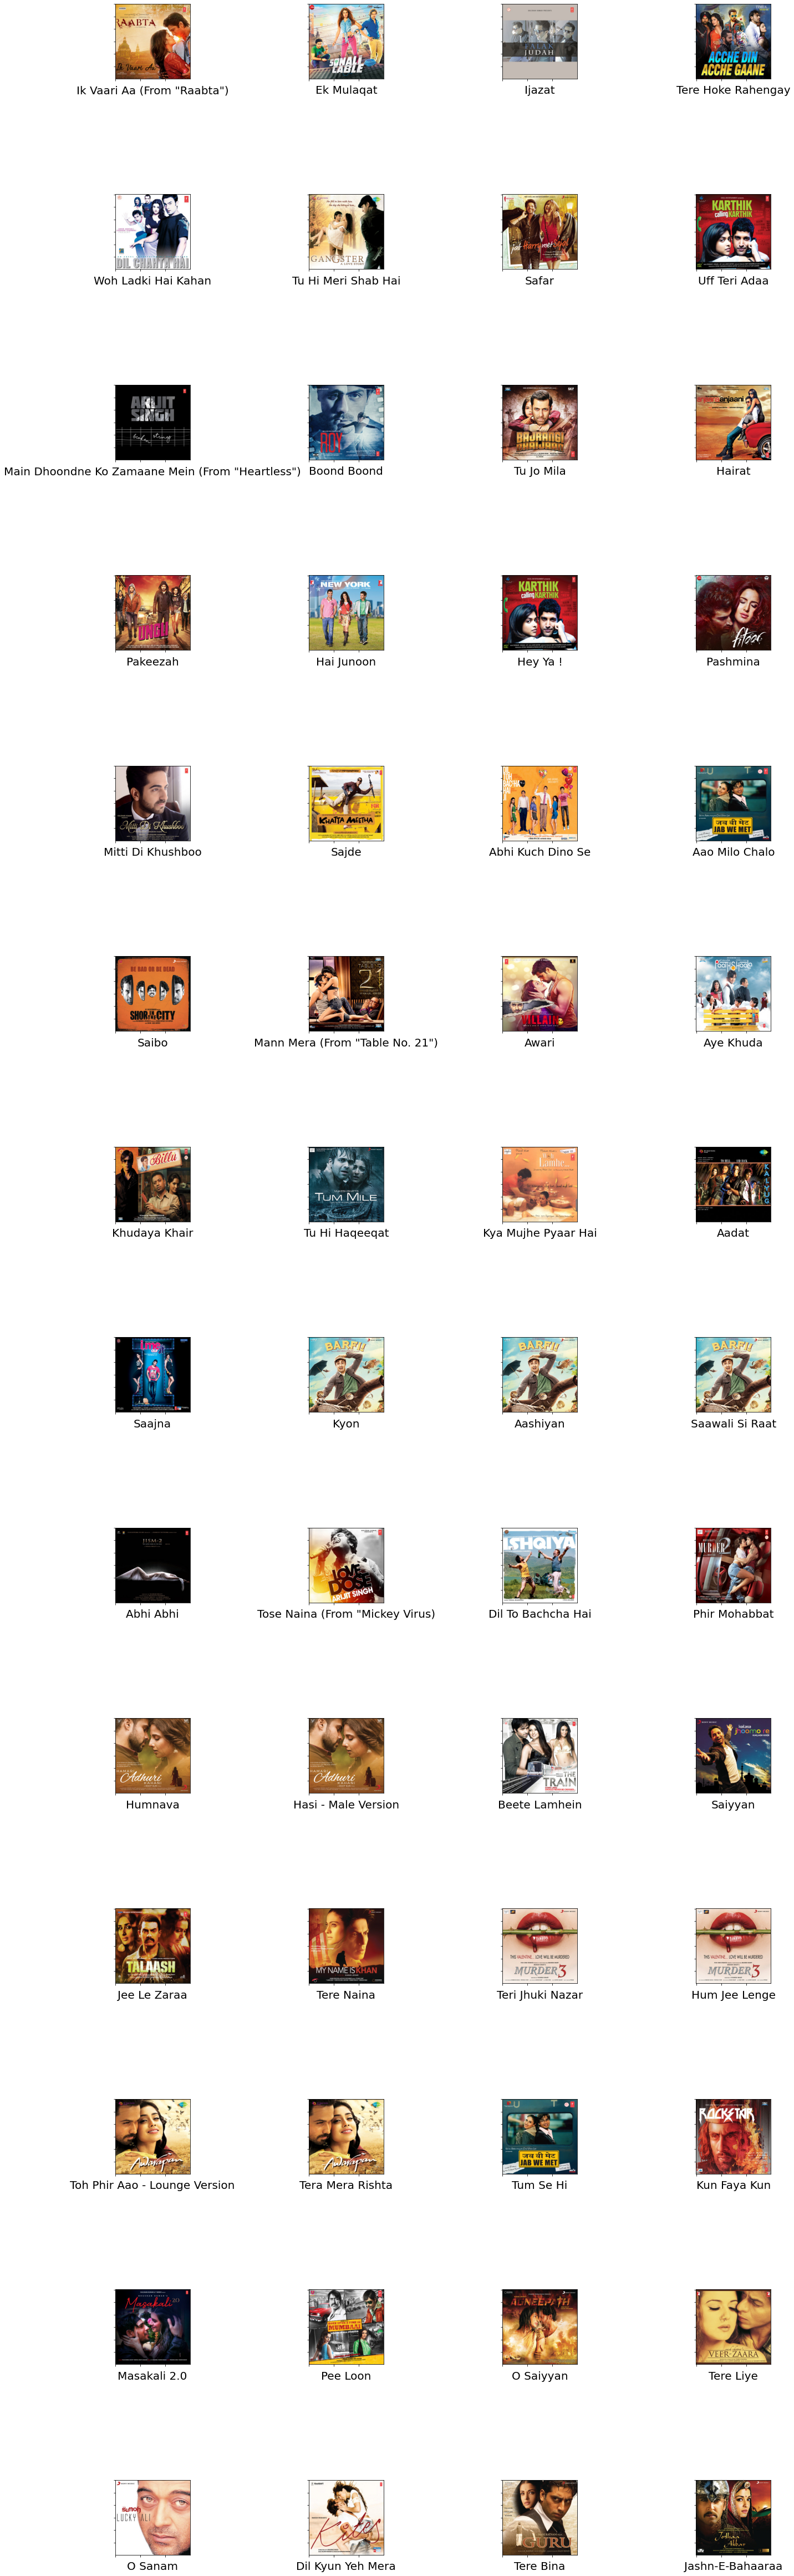

In [65]:
visualize_songs(playlist_vibrant)

##### We are generating the features of the user playlist as we have done for the above dataset
###### We are doing this by just comparing the id of the song present in the user playlist with the id of the songs present in our dataset and naming them as complete_feature_set_playlist_vector(USER PLAYLIST FEATURE DF) and  complete_feature_set_nonplaylist(ORIGINAL DATASET FEATURE DF)

In [66]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [67]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_vibrant, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [68]:
complete_feature_set_playlist_vector_EDM.shape

(2226,)

#### Here we are finding the similar songs according to user playlist with the help of [COSINE SIMILARITY](https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a)


In [69]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

#### Here are the top 40 songs recommended by the model

In [70]:
edm_top40 = generate_playlist_recos(df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [71]:
edm_top40

id                                        name  \
473214  32R7r1j2r13XwF62fT8sNt                         Manasellam Mazhaiye   
473173  4St20qfnH98z2CEY7Up5yn                                       Pungi   
474061  0QkHR2PDC4c8OzbVPCJ10T  Mohe Rang Do Laal (From "Bajirao Mastani")   
473787  4ZXsuOSu0vWtWMfmf1Gl3j                      Poolane Kunukeyamantaa   
474094  5wCxdYvu4KU0S8wyxY0EQT              Pinga (From "Bajirao Mastani")   
474142  1tghhViaNeUyYxqTDMteOb         Can't Forget You (Tujhe Bhula Diya)   
473695  1fkjRQA8wXPPyxqYLbxuqy                                Ishq Bulaava   
473223  3G2I8KB7bTWmvE1tHSlMHg                                     Laapata   
473786  5AM51LU4hTpGSdQEFQmZTw                              Galat Baat Hai   
473189  62wnQra2VgCUyHO3BUIAcr                             Jannatein Kahan   
474106  5JlZLXvZBEFD9u8OoJq6Yh                         Girls Like To Swing   
473186  2AAYoDgYtx5WCAg7Axeg70                                       Balma   
473181  70O5Rpo2B2FB4B5bf68JWw                        Apnaa Mujhe Tu Lagaa   
473210  1prGortu002OYC8sGfpAIj                                   Mashallah   
473796  7xxxQG1BupSnOBo4qId9kl                                 Drama Queen   
473127  2tva3nN2kQhBjHMC7Zlty6                        Deewana Kar Raha Hai   
473197  73yIZXOY6Th386dlZTZLju    Mar Jayian Romantic (From "Vicky Donor")   
473741  5Nuv6312XkkZd82AnnSc9g                Pookkalae Sattru Oyivedungal   
473747  0JJjxzyDzlSh4hbZvtvqVl                     Tu Zaroori (From "Zid")   
473165  7DbE178OOsJfJKyiNObOsw                                      Kukkad   
473190  0sSapNABKrGwgaMhn0p8uL                                  Long Drive   
473174  6wXPV6dNRAhFavrRaCdMXT                                      Challa   
473750  6alNZoLuClM6yFv3GnRANk                               Mast Kalander   
473758  1pwN1ldC7BTjip1hWQN6vJ                                 Caller Tune   
474082  7hhuXHAyn4egzc3do1Oiqe                       Heer Toh Badi Sad Hai   
473746  1FPhg4xpllC5P8lBDLMmfW                      Aathi (From "Kaththi")   
473732  0mboVyI4R4MPH23yceAMz3                                    Hangover   
474010  1kIaHdsk7dgJv11fANKeXg                                 Khoya Khoya   
473355  6YgqRJRUkekXVwN8hRK2Zo               Dil Ibaadat (From "Tum Mile")   
473727  3H43T5swYywvcdCBFiDgW6                                 Manwa Laage   
473783  78R4fDeRrcoBIxL6uX4TnJ                              Mersalaayitten   
473203  0koCvqji2k9Me2QJSjCzds                                      Lonely   
474090  46mXuHxCjDiLoLPsqn24P8                             Shaam Shaandaar   
473161  2VJIaxgWeyw9loL1sqKl7c                             Rab Ka Shukrana   
473160  5ZLplBxO5OmotTmYY8920p                                Navrai Majhi   
474056  5hRXhmEuQW3SJwX94BBV6u                                     Gulaabo   
472634  3FS3ItpUATpALLi90uvkde                                I Am In Love   
474033  0XCtA9pYB0aOciPzrJpkAK                                    Tu Chale   
474011  2Rk3SdNdkxKopRotoio2iZ    Deewani Mastani (From "Bajirao Mastani")   
473205  5Sif2EoFy6jvZ31s0wsB6Y                                Chup Chup Ke   

        popularity  duration_ms  explicit  \
473214          46       326495         0   
473173          48       247827         0   
474061          48       231838         0   
473787          45       308107         0   
474094          45       255169         0   
474142          46       279771         0   
473695          55       303640         0   
473223          45       254851         0   
473786          47       259627         0   
473189          46       228093         0   
474106          46       243166         0   
473186          46       227578         0   
473181          46       364019         0   
473210          49       283376         0   
473796          46       198747         0   
473127          58       338923         0   
473197          45       288960         0   
473741          50 

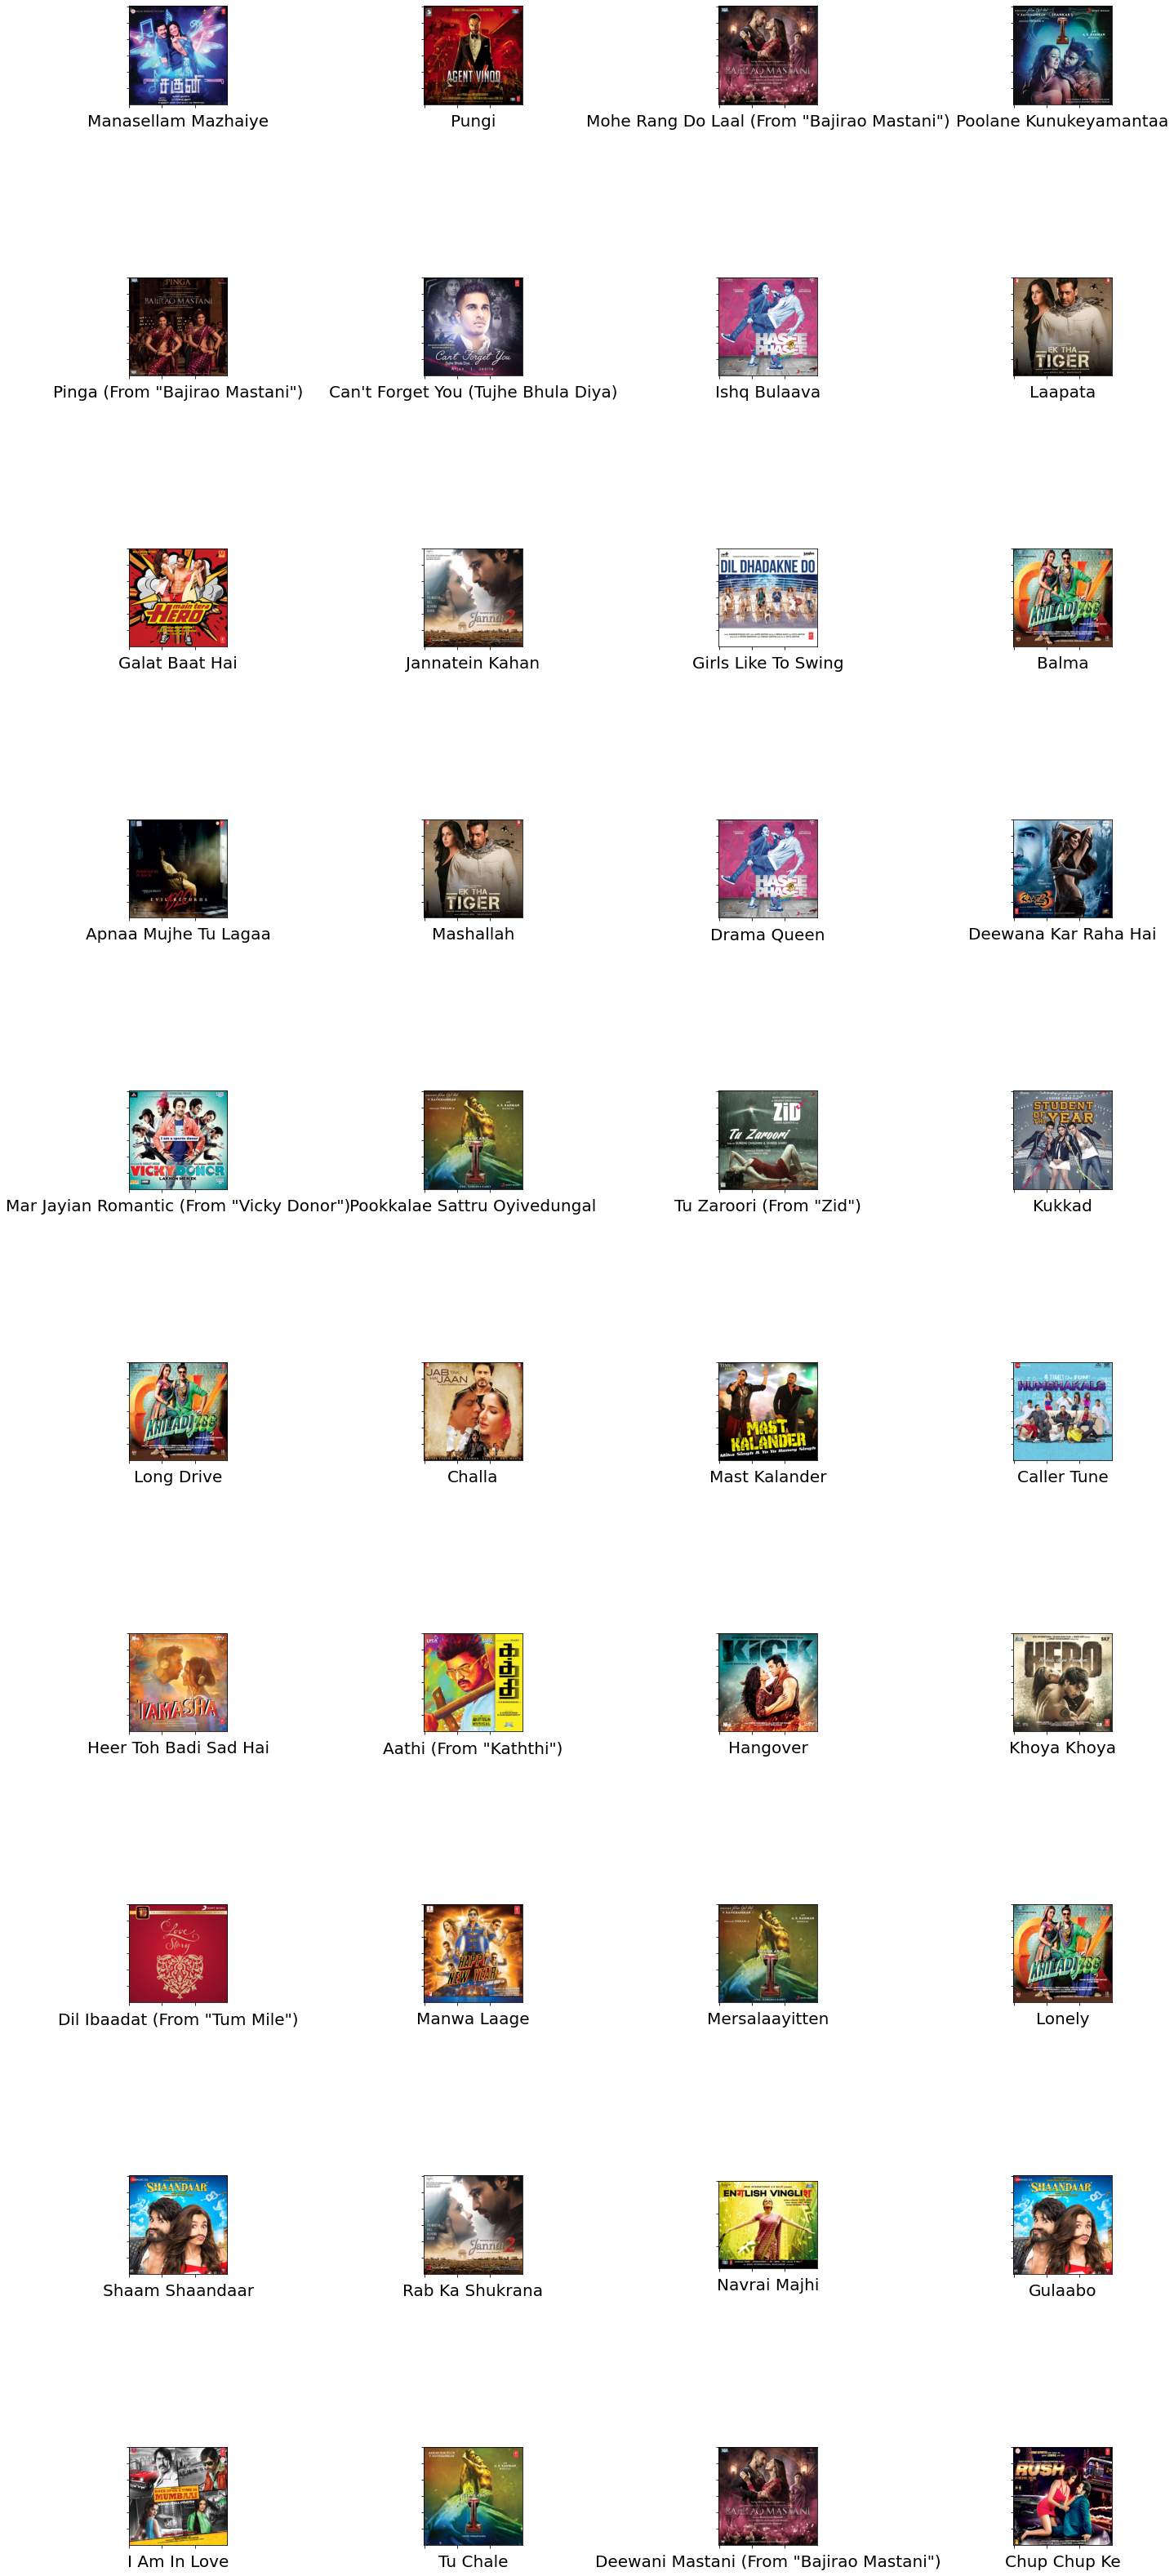

In [72]:
visualize_songs(edm_top40)